*Warning: много букв, но открытая постановка вопроса располагает к попыткам дойти до ответа из первых принципов.*

### Введение

Кластеризация в конечном счете - про расстояния и про то, как эти расстояния образуются интересными нам случайными процессами. Кластеры соответствует участкам сравнительно высокой плотности вероятности (например, моды) соответствующих распределений.

Поэтому мой подход таков:
1. Определиться с расстояниями
2. Определиться с вероятностной моделью
3. Вычислить, при каком числе кластеров модель лучше всего описывает данные (без оверфита)

### 1 Расстояние

Какое расстояние имеет смысл между бинарными векторами? Бинарный вектор обычно означает набор флагов, описывающих объект. Простой dot product будет равен числу совпадающих флагов-единиц. Выражение вида $n - \langle x,y \rangle$ + $\langle 1-x,1-y \rangle$ будет равно числу отличных битов (и нулей, и единиц) для векторов длины $n$. При такой мере вектор (1,1,0,0,0) будет одинаково близок к векторам (1,1,0,1,0) и (1,1,0,0,1). Легко представить признаки, равенство которых на практике имеет больший вес, чем равенство других. Предметная область может продиктовать конкретные веса, но в абстрактной постановке мера выше кажется разумной.


### 2 Вероятностный процесс

Подходящую модель предложит предметная область. В абстрактной постановке одна из простейших моделей - смесь многомерных распределений Бернулли. Если знать исходные распределения, то можно вывести их веса внутри смеси -- для этого есть алгоритмы вроде Expectation Maximization, но я воспользуюсь языком вероятностного программирования numpyro, инференс которого работает через mcmc. 

Почему? Я не нашел серьезных/готовых питониевых инструментов для Latent Class Analysis, и даже если бы они имелись, с numpyro работать веселее: вероятностное программирование - очень гибкий инструмент, не всегда простой, но от работы с ним больше пользы и удовлетворения, чем от работы с монолитным черным ящиком.

### 3 Число кластеров

Исходный вопрос - сколько кластеров? Смесь Бернуллей предполагает, что число и форма (в виде приора на элементы) кластеров-компонентов заданы извне, а инференс находит их веса. Значит, наиболее веорятные наборы кластеров нужно перебрать самому и сравнить качество построенных на них бернуллиевских смесей.

Для отыскания кластеров-кандидатов я решил использовать агломеративную кластеризацию. Почему? Алгоритмов кластеризации множество, включая намного более продвинутые, но агломеративная делает примерно то, что я бы делал вручную -- объединяет близкие вектора в группы все большего размера (и неоднородности). Перебирая пороги межкластерного расстояния (другими словами, делая отсечки на разных уровнях получившейся дендрограммы), получаем логичные кластеры-кандидаты для смеси.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
df = pd.read_excel('data/test_data_2.xlsx')

In [4]:
( df
 .apply(lambda row: ''.join(map(str, row)), axis=1)
 .value_counts()
 )

1010000    9
1110000    8
1110100    6
1101000    6
0100101    5
          ..
1100111    1
1100011    1
1010110    1
1110010    1
1101110    1
Name: count, Length: 78, dtype: int64

Уникальных векторов - 78, самый частый встречается 9 раз

In [1]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [69]:
#ac = AgglomerativeClustering(n_clusters=None, distance_threshold=0, 
#                             metric='precomputed', linkage='average')

In [87]:
ac = AgglomerativeClustering(n_clusters=None, 
                             distance_threshold=0, 
                             metric='precomputed', 
                             linkage='complete')

`distance_threshold=0` означает, что мы будем мержить кластеры до самого последнего;  
`metric=precomputed`: кастомная матрица расстояний;
С типом расстояния между кластерами (linkage) можно поспорить и в любом случае я экспериментировал с разными. Выбранная опция означает, что расстояние между кластерами равно максимальному расстоянию между членами кластеров, т.е. в нашем случае максимальное число бит, на которое отличаются вектора.   

In [6]:
metric = 7-((df.values) @ (df.values).T + (1-df.values) @ (1-df.values).T)

In [7]:
metric

array([[0, 3, 2, ..., 3, 3, 3],
       [3, 0, 1, ..., 2, 2, 2],
       [2, 1, 0, ..., 3, 1, 3],
       ...,
       [3, 2, 3, ..., 0, 2, 0],
       [3, 2, 1, ..., 2, 0, 2],
       [3, 2, 3, ..., 0, 2, 0]])

In [8]:
df.values[[0,1]]

array([[0, 1, 0, 1, 1, 1, 0],
       [0, 1, 0, 0, 1, 0, 1]])

Выше - матрица расстояний и для примера вектора 0 и 1, отличающиеся тремя позициями. Ниже - вспомогательные методы для быстрого подсчета расстояний

In [17]:
dist_str('1100011', '1100000')

np.int64(2)

In [9]:
def dist_str(s1: str, s2: str):
    x1 = np.array([int(x) for x in s1])
    x2 = np.array([int(x) for x in s2])
    return dist(x1, x2)

def dist(x1: np.ndarray, x2: np.ndarray):
    return 7-(x1 @ x2 + (1-x1) @ (1-x2))

In [88]:
ac = ac.fit(metric)

In [11]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

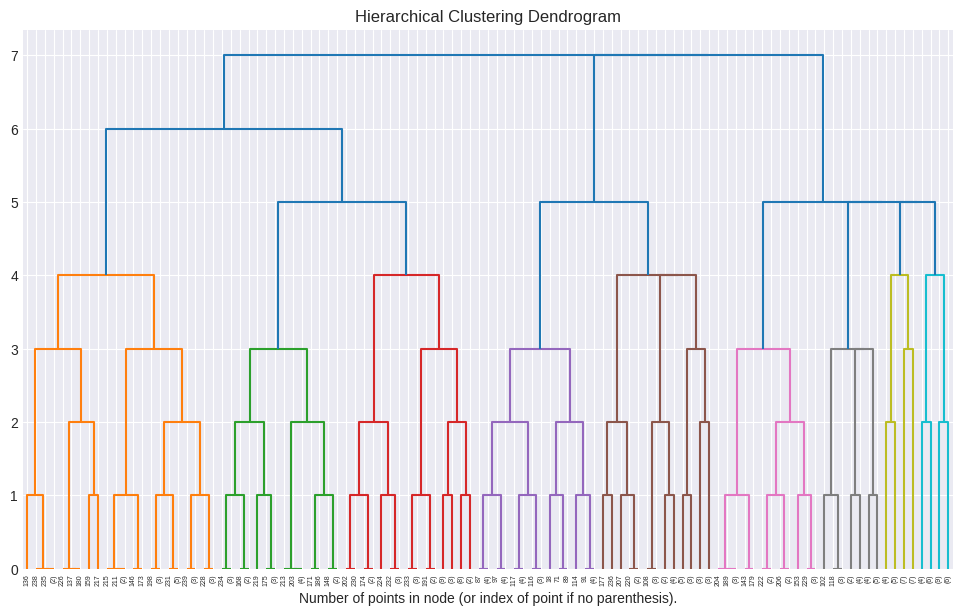

In [58]:
fig,ax=plt.subplots(figsize=(12,7))
ax.set_title("Hierarchical Clustering Dendrogram")
plot_dendrogram(ac, truncate_mode="level", p=6, ax=ax)
plt.xlabel("Number of points in node (or index of point if no parenthesis).");


Процедура отрисовки дендрограммы взята из sklearn-овского туториала. Дендрограмма для визуальной оценки, что все более-менее работает, как надо. 
Кластеризатор не хранит результируюшие кластеры, только ссылки на дочерние кластеры в поле `ac.children_`, поэтому кластеры нужно достать вручную, простым рекурсивным образом (`get_elems()`)

In [89]:
ac.distances_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 4.

In [16]:
def get_elems(ix, children):
    res_left = [int(children[ix][0])] if children[ix][0]<240 else get_elems(children[ix][0]-240, children) 
    res_right = [int(children[ix][1])] if children[ix][1]<240 else get_elems(children[ix][1]-240, children) 
    return res_left + res_right

In [93]:
clusters = [ (i,get_elems(i, ac.children_)) for i in range(len(ac.children_))]

In [94]:
# clusters with distance (max num of different bits) = k 
get_clusters = lambda thresh: [c for c,d in zip(clusters, ac.distances_) if d==thresh] 
clusters_final = [get_clusters(d) for d in range(2,7)]

In [85]:
# clusters with distance in a certain range (eg for average linkage) 
#get_clusters = lambda thresh: [c for c,d in zip(clusters, ac.distances_) if d>=thresh[0] and d<thresh[1]] 
#clusters_final = [get_clusters(d) for d in zip(np.linspace(0,6,10)[:-1], np.linspace(0,6,10)[1:])]

In [95]:
[len(c) for c in clusters_final]

[16, 10, 6, 5, 1]

Ниже для примера первый из кластеров, вектора в которых отличаются максимум на 4 бита. Всего таких кластеров шесть

In [68]:
for c,k in zip(clusters_final,[2,3,4,5,6]):
    for i in range(len(c)):
        tmp = df.values[c[i][1]]
        assert k == (7 - (tmp @ tmp.T + (1-tmp) @ (1-tmp).T)).max() 

In [65]:
df.values[clusters_final[2][0][1]]

array([[0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1],
       [0, 0, 1, 0, 1, 0, 1],
       [0, 0, 1, 0, 1, 0, 1],
       [0, 0, 1, 0, 1, 1, 1],
       [0, 0, 1, 0, 1, 1, 1],
       [0, 0, 1, 0, 1, 1, 1],
       [0, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 1],
       [0, 0, 1, 1, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 1, 1, 0, 1],
       [0, 0, 0, 1, 1, 0, 1],
       [0, 0, 0, 1, 1, 0, 1],
       [0, 0, 0, 1, 1, 0, 1]])

In [26]:
print(np.array_str(
    np.stack([df.values[c[1]].mean(axis=0) for c in clusters_final[2]]), 
    precision=2))

[[0.   0.   0.43 0.61 0.91 0.3  0.7 ]
 [0.   0.83 0.   0.67 0.5  1.   0.25]
 [0.   0.   0.52 1.   0.36 0.84 0.6 ]
 [0.2  0.87 0.   0.67 0.6  1.   0.33]
 [1.   0.44 1.   0.13 0.   0.26 0.31]
 [1.   1.   0.   0.71 0.38 0.21 0.38]]


Матрица выше получена так: берем вектора из каждого кластера с порогом по расстоянию 4. Берем их среднее в качестве оценки параметров распределения Бернулли. Эту матрицу (для каждого порога: 2, 3, 4, 5, 6) мы скормим numpyro для дальнейшего инференса

### Вероятностная модель

In [38]:
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.funsor import config_enumerate
import jax.numpy as jnp
import jax
from jax import random, vmap

In [46]:
@config_enumerate
def model(data, n_clusters, bernoullies):
    weights = numpyro.sample("weights", dist.Dirichlet(0.5 * jnp.ones(n_clusters)))
    
    with numpyro.plate('data', len(data)):
        assign = numpyro.sample('assignment', dist.Categorical(weights))
        numpyro.sample('obs', dist.Bernoulli(bernoullies[assign]).to_event(1), obs=data)

Модель такова: генерим веса распределений в смеси, затем с частотой пропорциональной этому весу берем семплы из соответствующего кластера.

Ниже - пример инференса для одного набора кластеров, но мне нужно перебрать все наборы.

In [34]:
from numpyro.infer import MCMC, NUTS

In [35]:
bernoullies = jnp.array(np.stack([df.values[c[1]].mean(axis=0) for c in clusters_final[2]]))
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_samples = 3000
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(
    rng_key_, 
    data = df.values, 
    n_clusters = bernoullies.shape[0],
    bernoullies = bernoullies
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/media/forveg/battleground/py_projects/service_ruki/env/lib/python3.10/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.ad.JVPTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/media/forveg/battleground/py_projects/service_ruki/env/lib/python3.10/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.ad.JVPTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
  0%|          | 0/4000 [00:00<?, ?it/s]/media/forveg/battleground/py_projects/service_ruki/env/lib/python3.10/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(

In [36]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
weights[0]      0.23      0.03      0.23      0.17      0.28   2195.06      1.00
weights[1]      0.08      0.05      0.08      0.00      0.15   1027.63      1.00
weights[2]      0.11      0.03      0.11      0.06      0.15   2228.70      1.00
weights[3]      0.09      0.06      0.09      0.00      0.17    976.66      1.00
weights[4]      0.27      0.03      0.27      0.22      0.32   3116.60      1.00
weights[5]      0.23      0.03      0.23      0.17      0.28   2048.39      1.00

Number of divergences: 0


In [39]:
from numpyro import handlers
from jax.scipy.special import logsumexp

In [40]:
def log_likelihood(rng_key, params, model, *args, **kwargs):
    model = handlers.seed(model, rng_key)
    model = handlers.condition(model, params)
    model_trace = handlers.trace(model).get_trace(*args, **kwargs)
    obs_node = model_trace["obs"]
    return obs_node["fn"].log_prob(obs_node["value"])


def log_pred_density(rng_key, params, model, *args, **kwargs):
    n = list(params.values())[0].shape[0]
    log_lk_fn = vmap(
        lambda rng_key, params: log_likelihood(rng_key, params, model, *args, **kwargs)
    )
    log_lk_vals = log_lk_fn(random.split(rng_key, n), params)
    return (logsumexp(log_lk_vals, 0) - jnp.log(n)).sum()


In [47]:
mcmcs = []
for clusters in clusters_final:
    bernoullies = jnp.array(np.stack([df.values[c[1]].mean(axis=0) for c in clusters]))

    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)

    num_samples = 3000
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
    mcmc.run(
        rng_key_, 
        data = df.values, 
        n_clusters = bernoullies.shape[0], 
        bernoullies = bernoullies
    )
    mcmcs.append(mcmc)

/media/forveg/battleground/py_projects/service_ruki/env/lib/python3.10/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.ad.JVPTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
  0%|          | 0/4000 [00:00<?, ?it/s]/media/forveg/battleground/py_projects/service_ruki/env/lib/python3.10/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/media/forveg/battleground/py_projects/service_ruki/env/lib/python3.10/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/media/forveg/battleground/py_projects/service_ruki/env/lib/python3.10/site-packages/jax/_s

In [49]:
rng_key, rng_key_ = random.split(rng_key)
log_probs = []
for i,mcmc in enumerate(mcmcs):
    samples = mcmc.get_samples()
    bernoullies = jnp.array(np.stack([df.values[c[1]].mean(axis=0) for c in clusters_final[i]]))

    log_prob = log_pred_density(
            rng_key_,
            samples,
            model,
            data = df.values,
            n_clusters=bernoullies.shape[0],
            bernoullies=bernoullies,
        )
    log_probs.append(log_prob)

In [96]:
[len(x) for x in clusters_final]

[16, 10, 6, 5, 1]

In [50]:
list(zip([len(x) for x in clusters_final],log_probs))

[(16, Array(-1881.2703, dtype=float32)),
 (10, Array(-1466.0188, dtype=float32)),
 (6, Array(-4394.3604, dtype=float32)),
 (5, Array(-1105.3668, dtype=float32)),
 (1, Array(-2989.8936, dtype=float32))]

Если судить по лог-правдоподобию данных относительно модели, наиболее вероятным числом кластеров является пять, хотя все вероятности очень низкие.

В рамках данного подхода можно экспериментировать дальше и на стороне выбора кластеров-кандидатов, и на стороне оценки качества моделей.

### Что все это значит и что с этим делать

Описать полученные кластеры можно по оценкам вероятностей соответствующих Бернуллей. В нашем случае, например, в первых двух кластерах первые два признака всегда ложны, а в последнем первый и третий - всегда истинны.

В более практическом контексте могу представить размышления следующего вида: вот очередной семпл из нашей доменной популяции, например, клиент, которого мы описываем вектором категорий товаров, которые он покупал, или вектором профессиональных харакетристик (образование, занятость и пр). К какому кластеру его отнести? Считаем вероятность принадлежности его каждому кластеру и сравниваем. 

При этом вероятностный характер модели позволяет отнести его к нескольким вероятным кластерам или даже спрогнозировать переход между кластерами (такую динамику можно моделировать марковскими цепями, если оставаться в ареале классических моделей), что логично, т.к. кластеры описывают участки повышенной плотности ("высокой" в конкретном контексте; уровень можно регулировать), а не статичные изолированные явления.

In [ ]:
print(np.array_str(
    np.stack([ df.values[clusters_final[-2][i][1]].mean(axis=0) for i in range(5)]),
    precision=2))

[[0.   0.   0.48 0.81 0.62 0.58 0.65]
 [0.   0.   0.63 0.65 0.6  0.62 0.51]
 [0.1  0.93 0.   0.55 0.64 0.52 0.4 ]
 [0.21 0.   0.71 0.72 0.6  0.65 0.53]
 [1.   0.45 1.   0.08 0.37 0.27 0.39]]


In [ ]:
jnp.median(mcmcs[-2].get_samples()['weights'], axis=0)

Array([0.01389814, 0.02056143, 0.38595408, 0.30743325, 0.2511279 ],      dtype=float32)

А еще можно созерцать матрицы расстояний и искать в них интересные паттерны

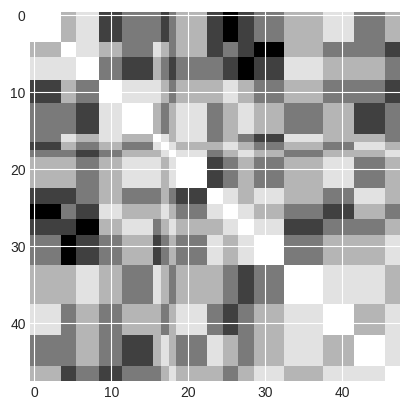

In [131]:
tmp = df.values[clusters_final[-2][0][1]]
plt.imshow(7 - (tmp @ tmp.T + (1-tmp) @ (1-tmp).T ));